# Setup

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import pandas as pd

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"

sns.set_style('whitegrid')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
#!pip install seaborn --quiet

## Load the data

In [2]:
df = pd.read_csv("soc-sign-bitcoinalpha.csv.gz", names=["SOURCE", "TARGET", "RATING", "TIME"])
df

,SOURCE,TARGET,RATING,TIME
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


In [3]:
df['TIME'] = (df['TIME'] - df['TIME'].min())

In [20]:
mean = df['TIME'].mean()

In [21]:
teste = df.query(f'TIME <= {mean}')

In [22]:
len(teste)

12485

In [28]:
# plt.hist(df['TIME'])

# Modelo usando SOURCE

A principio, vamos tentar modelar ignorando os targets e os ratings. Nesse caso, estamos considerando a sequencia de ratings de cada source uma avaliacao do TPP. Dessa forma, esperamos que o modelo aprenda como uma unica source realiza seus ratings no tempo.

In [24]:
grouped = df.groupby(['SOURCE'])['TIME'].apply(list).reset_index(name='TIMES_PRE')
def foo(ls):
    threshold = 1.25e8
    return [x for x in ls if x <= threshold]
grouped['TIMES'] = grouped['TIMES_PRE'].apply(lambda ts : foo(ts))

In [26]:
grouped.head()

,SOURCE,TIMES_PRE,TIMES
0,1,"[27990000, 59612400, 89161200, 82854000, 81644...","[27990000, 59612400, 89161200, 82854000, 81644..."
1,2,"[122770800, 53910000, 105231600, 1728000, 9072...","[122770800, 53910000, 105231600, 1728000, 9072..."
2,3,"[83804400, 65836800, 72748800, 103075200, 7568...","[83804400, 65836800, 72748800, 103075200, 7568..."
3,4,"[10454400, 9072000, 20127600, 12697200, 482076...","[10454400, 9072000, 20127600, 12697200, 482076..."
4,5,"[97977600, 94435200, 91234800, 96249600, 80953...","[97977600, 94435200, 91234800, 96249600, 80953..."


In [49]:
def get_inter_times(t, t_end):
    t.sort()
    tau = np.diff(t, prepend=0.0, append=t_end)
    return torch.tensor(tau, dtype=torch.float32, device=device)

t_ends = torch.tensor([
    torch.tensor(l[-1], dtype=torch.long, device=device) for l in grouped['TIMES'].values if len(l) > 0])
print(t_ends.max().item())
t_end = t_ends.max().item() #+ 1e8
seq_lengths = torch.tensor(
    [len(t) for t in grouped['TIMES'].values], dtype=torch.long
)  # (B,)
rating_times_list = [get_inter_times(x, t_end) for x in grouped['TIMES'].values]
rating_times = pad_sequence(rating_times_list, batch_first=True)  # (B, L)

## important

t_end = t_ends.max()

124930800


Para o `t_end`, estou utilizando o maior valor de timestamp da base de dados + $10^8$:

In [70]:
rating_times.shape

torch.Size([3286, 477])

In [77]:
unique_values.shape, counts.shape

(torch.Size([2147]), torch.Size([2147]))

In [79]:
sorted_values, sorted_indices = torch.sort(unique_values)
sorted_values.shape

torch.Size([2147])

In [80]:
import torch

# Your 2D tensor with 1247 unique values
tensor_2d = torch.tensor([[5, 12, 3],
                          [8, 2, 15],
                          ...])  # Replace ... with your values

# Flatten the tensor
flattened_tensor = tensor_2d.flatten()

# Get unique values and their counts
unique_values, counts = torch.unique(flattened_tensor, return_counts=True)

# Sort unique values
sorted_values, sorted_indices = torch.sort(unique_values)

# Create a dictionary to map each value to its index
index_map = {value.item(): index.item() for value, index in zip(sorted_values, sorted_indices)}

# Map values to indices
mapped_indices = torch.tensor([index_map[value.item()] for value in flattened_tensor])

# Reshape the mapped indices back to the original shape
mapped_indices_2d = mapped_indices.view(tensor_2d.size())

print(mapped_indices_2d)


RuntimeError: Could not infer dtype of ellipsis

In [74]:
sorted_indices

tensor([[  3,  11,  12,  ..., 457, 470,   4],
        [  0,   4,  10,  ..., 189, 154, 161],
        [  1,   2,   4,  ..., 222, 243,   0],
        ...,
        [  1,   2,   3,  ...,   7,  13,   0],
        [  2,   7,   8,  ...,  41,   0,  66],
        [  1,   3,   4,  ...,  17,  21,   0]])

## Choose a parametric distribution

In [51]:
class Weibull:
    """Weibull distribution.

    Args:
        b: scale parameter b (strictly positive)
        k: shape parameter k (strictly positive)
        eps: Minimum value of x, used for numerical stability.
    """
    def __init__(self, b, k, eps=1e-8):
        self.b = b
        self.k = k
        self.eps = eps

    def log_prob(self, x):
        """Logarithm of the probability density function log(f(x))."""
        # x must have the same shape as self.b and self.k
        x = x.clamp_min(self.eps)  # pow is unstable for inputs close to 0
        return (self.b.log() + self.k.log() + (self.k - 1) * x.log()
                + self.b.neg() * torch.pow(x, self.k))

    def log_survival(self, x):
        """Logarithm of the survival function log(S(x))."""
        x = x.clamp_min(self.eps)
        return self.b.neg() * torch.pow(x, self.k)

    def sample(self, sample_shape=torch.Size()):
        """Generate a sample from the distribution."""
        # We do sampling using the inverse transform method
        # If z ~ Expo(1), then solving exp(-z) = S(x) for x produces
        # a sample from the distribution with survival function S
        shape = torch.Size(sample_shape) + self.b.shape
        z = torch.empty(shape).exponential_(1.0)
        return (z * self.b.reciprocal() + self.eps).pow(self.k.reciprocal())

## Define the model

In [52]:
class NeuralTPP(nn.Module):
    """A simple neural TPP model with an RNN encoder.

    Args:
        context_size: Size of the RNN hidden state.
    """
    def __init__(self, context_size=32):
        super().__init__()
        self.context_size = context_size
        # Used to embed the event history into a context vector
        self.rnn = nn.GRU(
            input_size=2,
            hidden_size=context_size,
            batch_first=True,
        )
        # Used to obtain model parameters from the context vector
        self.hypernet = nn.Linear(
            in_features=context_size,
            out_features=2,
        )

    def get_context(self, inter_times):
        """Get context embedding for each event in each sequence.

        Args:
            inter_times: Padded inter-event times, shape (B, L)

        Returns:
            context: Context vectors, shape (B, L, C)
        """
        tau = inter_times.unsqueeze(-1)
        # Clamp tau to avoid computing log(0) for padding and getting NaNs
        log_tau = inter_times.clamp_min(1e-8).log().unsqueeze(-1)  # (B, L, 1)
        rnn_input = torch.cat([tau, log_tau], dim=-1)
        # The intial state is automatically set to zeros
        rnn_output = self.rnn(rnn_input)[0]  # (B, L, C)
        # Shift by one such that context[:, i] will be used
        # to parametrize the distribution of inter_times[:, i]
        context = F.pad(rnn_output[:, :-1, :], (0, 0, 1, 0))  # (B, L, C)
        return context

    def get_inter_time_distribution(self, context):
        """Get context embedding for each event in each sequence.

        Args:
            context: Context vectors, shape (B, L, C)

        Returns:
            dist: Conditional distribution over the inter-event times
        """
        raw_params = self.hypernet(context)  # (B, L, 2)
        b = F.softplus(raw_params[..., 0])  # (B, L)
        k = F.softplus(raw_params[..., 1])  # (B, L)
        return Weibull(b=b, k=k)

    def nll_loss(self, inter_times, seq_lengths):
        """Compute negative log-likelihood for a batch of sequences.

        Args:
            inter_times: Padded inter_event times, shape (B, L)
            seq_lengths: Number of events in each sequence, shape (B,)

        Returns:
            log_p: Log-likelihood for each sequence, shape (B,)
        """
        context = self.get_context(inter_times)  # (B, L, C)
        inter_time_dist = self.get_inter_time_distribution(context)

        log_pdf = inter_time_dist.log_prob(inter_times)  # (B, L)
        # Construct a boolean mask that selects observed events
        arange = torch.arange(inter_times.shape[1], device=seq_lengths.device)
        mask = (arange[None, :] < seq_lengths[:, None]).float()  # (B, L)
        log_like = (log_pdf * mask).sum(-1)  # (B,)

        log_surv = inter_time_dist.log_survival(inter_times)  # (B, L)
        end_idx = seq_lengths.unsqueeze(-1)  # (B, 1)
        log_surv_last = torch.gather(log_surv, dim=-1, index=end_idx)  # (B, 1)
        log_like += log_surv_last.squeeze(-1)  # (B,)
        return -log_like

    def sample(self, batch_size, t_end):
        """Generate an event sequence from the TPP.

        Args:
            batch_size: Number of samples to generate in parallel.
            t_end: Time until which the TPP is simulated.

        Returns:
            inter_times: Padded inter-event times, shape (B, L)
            seq_lengths: Number of events in each sequence, shape (B,)
        """
        inter_times = torch.empty([batch_size, 0])
        next_context = torch.zeros(batch_size, 1, self.context_size)
        generated = False
        while not generated:
            inter_time_dist = self.get_inter_time_distribution(next_context)
            next_inter_times = inter_time_dist.sample()  # (B, 1)
            inter_times = torch.cat([inter_times, next_inter_times], dim=1)  # (B, L)

            # Obtain the next context vector
            tau = next_inter_times.unsqueeze(-1)  # (B, 1, 1)
            log_tau = next_inter_times.clamp_min(1e-8).log().unsqueeze(-1)  # (B, 1, 1)
            rnn_input = torch.cat([tau, log_tau], dim=-1)  # (B, 1, 2)
            next_context = self.rnn(rnn_input, next_context.transpose(0, 1))[0]  # (B, 1, C)

            # Check if the end of the interval has been reached#
            generated = inter_times.sum(-1).min() >= t_end
        # Convert the sample to their same format as our input data
        arrival_times = inter_times.cumsum(-1)
        seq_lengths = (arrival_times < t_end).sum(-1).long()
        inter_times = arrival_times - F.pad(arrival_times, (1, 0))[..., :-1]
        return inter_times, seq_lengths

In [53]:
a, b = torch.sort(rating_times)

## Train the model

In [55]:
model = NeuralTPP()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

max_epochs = 300
for epoch in range(max_epochs + 1):
    opt.zero_grad()
    loss = model.nll_loss(a, seq_lengths).mean() / t_end
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.7f}")

Epoch 0: loss = 0.0002484
Epoch 50: loss = 0.0000004
Epoch 100: loss = -0.0000001
Epoch 150: loss = -0.0000004
Epoch 200: loss = -0.0000004
Epoch 250: loss = -0.0000005
Epoch 300: loss = -0.0000006


In [57]:
t_end

tensor(124930800)

## Sample event sequences from the model

In [60]:
with torch.no_grad():
    gen_inter_times, gen_seq_lengths = model.sample(1000, 5) #t_end
gen_arrival_times = gen_inter_times.cumsum(-1)
generated_sequences = []
for i in range(gen_arrival_times.shape[0]):
    t = gen_arrival_times[i, :gen_seq_lengths[i]].cpu().numpy()
    generated_sequences.append(t)

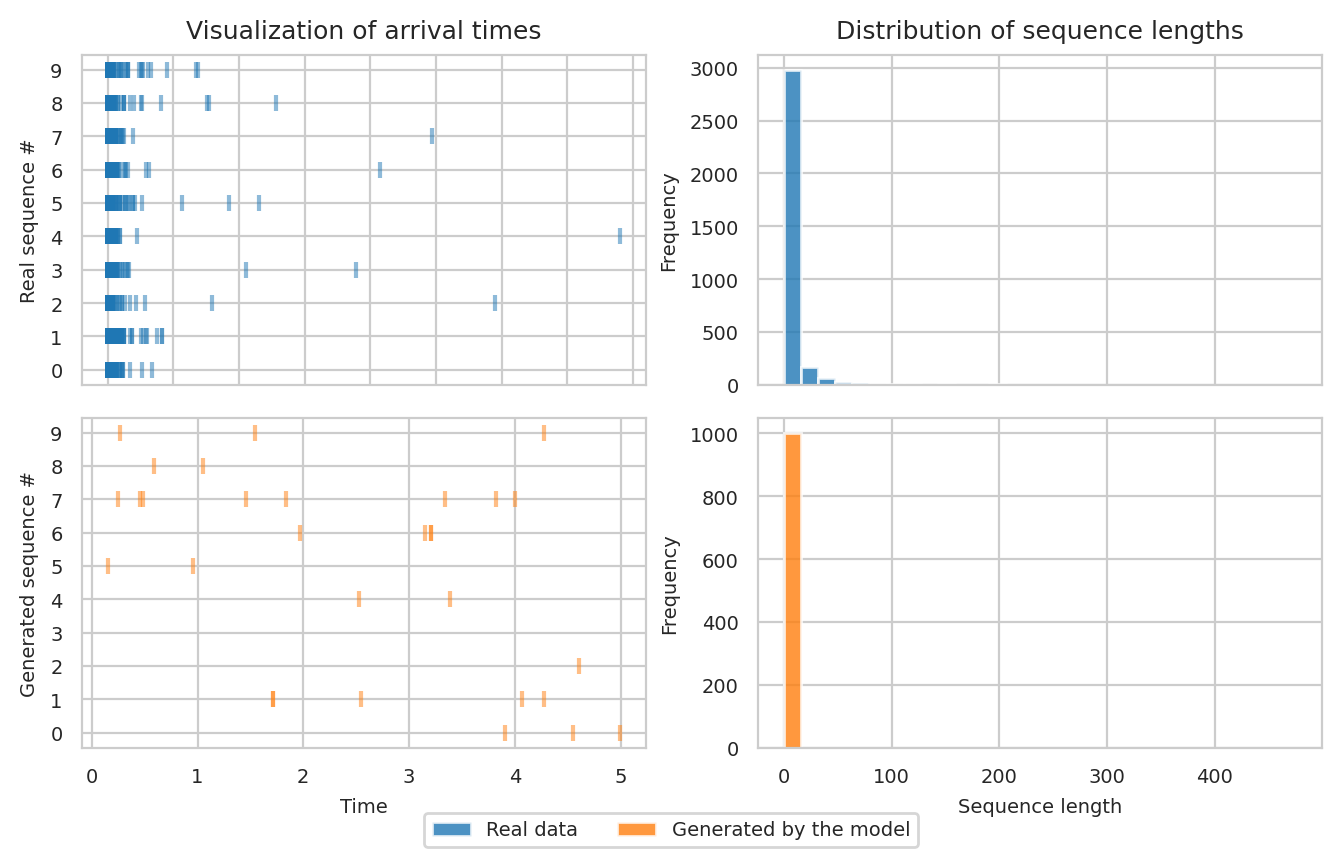

In [63]:
fig, axes = plt.subplots(figsize=[8, 4.5], dpi=200, nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(rating_times_list[:10]):
    axes[0, 0].scatter(t.cpu(), np.ones_like(t.cpu()) * idx, alpha=0.5, c='C0', marker="|")
axes[0, 0].set_ylabel("Real sequence #", fontsize=7)
axes[0, 0].set_yticks(np.arange(10));
axes[0, 0].set_title("Visualization of arrival times", fontsize=9)


for idx, t in enumerate(generated_sequences[:10]):
    axes[1, 0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C1', marker="|")
axes[1, 0].set_xlabel("Time", fontsize=7)
axes[1, 0].set_ylabel("Generated sequence #", fontsize=7)
axes[1, 0].set_yticks(np.arange(10))
axes[0, 0].set_xticklabels([])

for ax in np.ravel(axes):
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

axes[0, 1].set_title("Distribution of sequence lengths", fontsize=9)
q_min = min(seq_lengths.min(), gen_seq_lengths.min())
q_max = max(seq_lengths.max(), gen_seq_lengths.max())
axes[0, 1].hist(seq_lengths, 30, alpha=0.8, color="C0", range=(q_min, q_max), label="Real data");
axes[0, 1].set_ylabel("Frequency", fontsize=7)
axes[0, 1].set_xticklabels([])

axes[1, 1].hist(gen_seq_lengths, 30, alpha=0.8, color="C1", range=(q_min, q_max), label="Generated by the model");
axes[1, 1].set_xlabel(r"Sequence length", fontsize=7)
axes[1, 1].set_ylabel("Frequency", fontsize=7)

fig.legend(loc="lower center", ncol=2, fontsize=7)

# Modelo usando TARGET

Agora vamos considerar a sequência de ratings de cada target uma avaliação do TPP. Dessa forma, esperamos que o modelo aprenda como um único target recebe ratings no tempo.

In [ ]:
grouped = df.groupby(['TARGET'])['TIME'].apply(list).reset_index(name='TIMES')
grouped['TIMES'].values[0][-1]

1301976000

In [ ]:
def get_inter_times(t, t_end):
    t.sort()
    tau = np.diff(t, prepend=0.0, append=t_end)
    return torch.tensor(tau, dtype=torch.float32, device=device)

t_ends = torch.tensor([
    torch.tensor(l[-1], dtype=torch.long, device=device) for l in grouped['TIMES'].values
])
print(t_ends.max().item())
t_end = t_ends.max().item() + 1e8
print(t_end)
#t_end = 2000000000
seq_lengths = torch.tensor(
    [len(t) for t in grouped['TIMES'].values], dtype=torch.long
)  # (B,)
rating_times_list = [get_inter_times(x, t_end) for x in grouped['TIMES'].values]
rating_times = pad_sequence(rating_times_list, batch_first=True)  # (B, L)
print(len(rating_times[0]))
print(seq_lengths[0])

1453438800
1553438800.0
399
tensor(398)


In [ ]:
model = NeuralTPP()
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

max_epochs = 150
for epoch in range(max_epochs + 1):
    opt.zero_grad()
    loss = model.nll_loss(rating_times, seq_lengths).mean() / t_end
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.7f}")

Epoch 0: loss = 0.0002577
Epoch 50: loss = 0.0000338
Epoch 100: loss = 0.0000164
Epoch 150: loss = 0.0000104


In [ ]:
with torch.no_grad():
    gen_inter_times, gen_seq_lengths = model.sample(1000, t_end)
gen_arrival_times = gen_inter_times.cumsum(-1)
generated_sequences = []
for i in range(gen_arrival_times.shape[0]):
    t = gen_arrival_times[i, :gen_seq_lengths[i]].cpu().numpy()
    generated_sequences.append(t)

In [ ]:
seq_lengths = seq_lengths.cpu().numpy()
gen_seq_lengths = gen_seq_lengths.cpu().numpy()

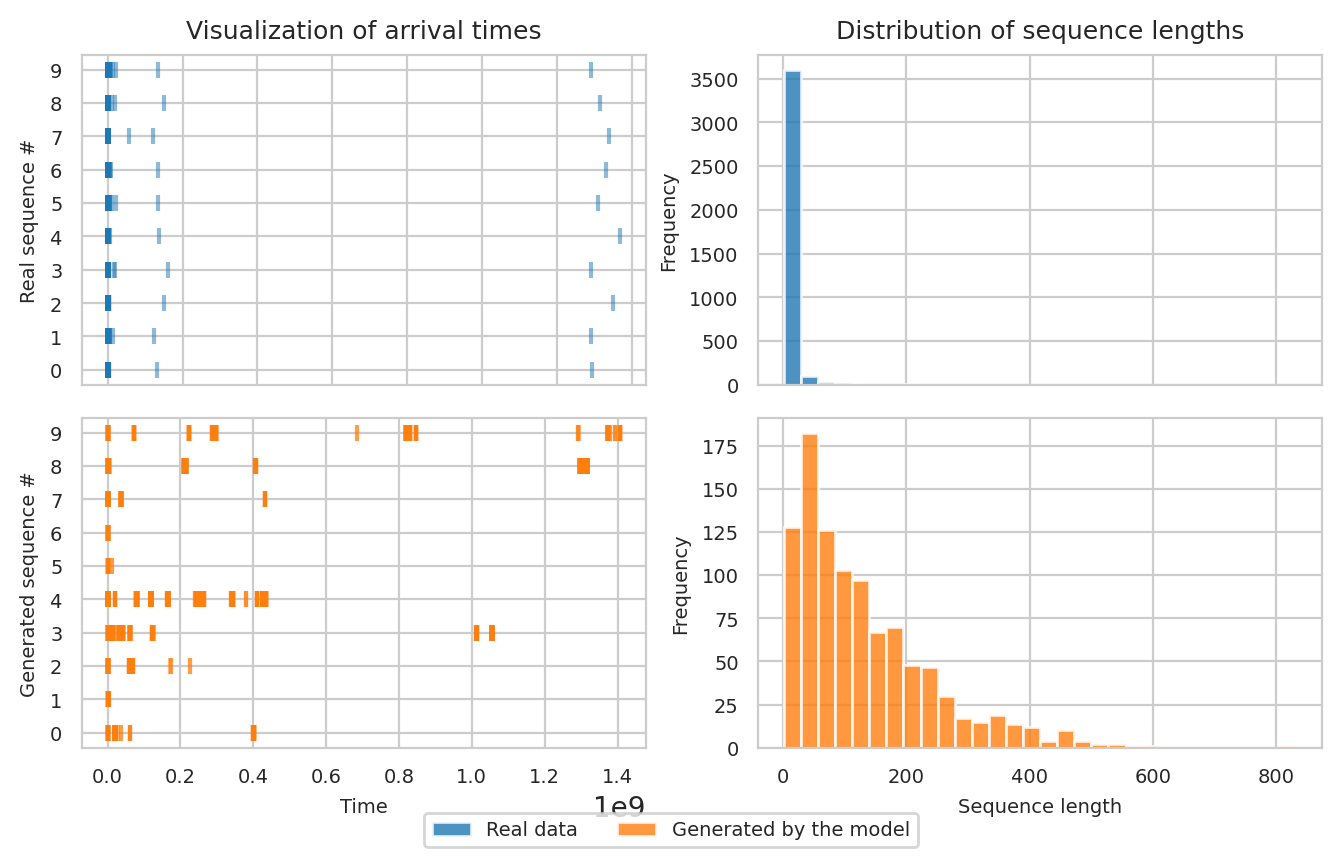

In [ ]:
N = 10

fig, axes = plt.subplots(figsize=[8, 4.5], dpi=200, nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(rating_times_list[:N]):
    axes[0, 0].scatter(t.cpu(), np.ones_like(t.cpu()) * idx, alpha=0.5, c='C0', marker="|")
axes[0, 0].set_ylabel("Real sequence #", fontsize=7)
axes[0, 0].set_yticks(np.arange(N));
axes[0, 0].set_title("Visualization of arrival times", fontsize=9)


for idx, t in enumerate(generated_sequences[:N]):
    axes[1, 0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C1', marker="|")
axes[1, 0].set_xlabel("Time", fontsize=7)
axes[1, 0].set_ylabel("Generated sequence #", fontsize=7)
axes[1, 0].set_yticks(np.arange(N))
axes[0, 0].set_xticklabels([])

for ax in np.ravel(axes):
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

axes[0, 1].set_title("Distribution of sequence lengths", fontsize=9)
q_min = min(seq_lengths.min(), gen_seq_lengths.min())
q_max = max(seq_lengths.max(), gen_seq_lengths.max())
axes[0, 1].hist(seq_lengths, 30, alpha=0.8, color="C0", range=(q_min, q_max), label="Real data");
axes[0, 1].set_ylabel("Frequency", fontsize=7)
axes[0, 1].set_xticklabels([])

axes[1, 1].hist(gen_seq_lengths, 30, alpha=0.8, color="C1", range=(q_min, q_max), label="Generated by the model");
axes[1, 1].set_xlabel(r"Sequence length", fontsize=7)
axes[1, 1].set_ylabel("Frequency", fontsize=7)

fig.legend(loc="lower center", ncol=2, fontsize=7)